In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import gc

from shared.utils import *
from shared.kaggle_path import *

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

strategy = tf.distribute.MirroredStrategy()

2025-05-06 08:04:44.911348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 08:04:44.911401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-06 08:04:44.913195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preprocessing
## Audio data

In [2]:
label = []
filepath = []

for classes in os.listdir(AUDIO_PATH):
    for file in os.listdir(os.path.join(AUDIO_PATH, classes)):
        file_path = os.path.join(AUDIO_PATH, classes, file)

        filepath.append(file_path)
        label.append(classes)

audio = pd.DataFrame({
    'filepath': filepath,
    'label': label,
})

del filepath, label

audio.head()

,filepath,label
0,/kaggle/working/dataset/audio/sad/1049_WSI_SAD...,sad
1,/kaggle/working/dataset/audio/sad/OAF_merge_sa...,sad
2,/kaggle/working/dataset/audio/sad/1054_DFA_SAD...,sad
3,/kaggle/working/dataset/audio/sad/OAF_search_s...,sad
4,/kaggle/working/dataset/audio/sad/1086_IWW_SAD...,sad


In [3]:
le = LabelEncoder()
le.fit(audio['label'])
audio['label_encoded'] = le.transform(audio['label'])
num_classes = len(le.classes_)

In [5]:
# with tf.device('/GPU:0'):
with strategy.scope():
    audio['data'] = audio.filepath.apply(preprocess_audio)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=544
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1888
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=576
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1824
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1216
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=448
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:26

In [6]:
x_audio = np.stack(audio['data'].values)
y_audio = audio['label_encoded'].values
print(x_audio.shape)
del audio

(27406, 128, 110, 3)


In [7]:
x_audio_train, x_temp, y_audio_train, y_temp = train_test_split(
    x_audio, y_audio, test_size=0.3, random_state=42, shuffle=True
)

x_audio_val, x_audio_test, y_audio_val, y_audio_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42,
)

del x_audio, y_audio
print(x_audio_train.shape)

(19184, 128, 110, 3)


In [8]:
x_audio_train.shape[0] == len(y_audio_train)

True

## Image Data

In [9]:
filepath = []
label = []

i = 0
for classes in os.listdir(TRAIN_IMAGE_PATH):
    for file in os.listdir(os.path.join(TRAIN_IMAGE_PATH, classes)):
        path = os.path.join(TRAIN_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

train_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(train_df.shape)
print(train_df['label'].unique())
train_df.head()

(28709, 2)
['sad' 'surprise' 'happy' 'neutral' 'fear' 'disgust' 'angry']


,filepath,label
0,/kaggle/working/dataset/new_data/train/sad/Tra...,sad
1,/kaggle/working/dataset/new_data/train/sad/Tra...,sad
2,/kaggle/working/dataset/new_data/train/sad/Tra...,sad
3,/kaggle/working/dataset/new_data/train/sad/Tra...,sad
4,/kaggle/working/dataset/new_data/train/sad/Tra...,sad


In [10]:
filepath = []
label = []

i = 0
for classes in os.listdir(TEST_IMAGE_PATH):
    for file in os.listdir(os.path.join(TEST_IMAGE_PATH, classes)):
        path = os.path.join(TEST_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

img_test_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(img_test_df.shape)
print(img_test_df['label'].unique())
img_test_df.head()

(7311, 2)
['sad' 'surprise' 'happy' 'neutral' 'fear' 'disgust' 'angry']


,filepath,label
0,/kaggle/working/dataset/new_data/test/sad/Priv...,sad
1,/kaggle/working/dataset/new_data/test/sad/Priv...,sad
2,/kaggle/working/dataset/new_data/test/sad/Publ...,sad
3,/kaggle/working/dataset/new_data/test/sad/Priv...,sad
4,/kaggle/working/dataset/new_data/test/sad/Priv...,sad


In [11]:
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label_encoded'] = le.transform(train_df['label'])
img_test_df['label_encoded'] = le.transform(img_test_df['label'])

In [12]:
# with tf.device('/GPU:0'):
with strategy.scope():
    train_df['data'] = train_df['filepath'].apply(lambda x : preprocess_image(x, (100, 100)))
    img_test_df['data'] = img_test_df['filepath'].apply(lambda x : preprocess_image(x, (100, 100)))

train_df.shape

(28709, 4)

In [13]:
x_img = np.stack(train_df['data'].values)
y_img = train_df['label_encoded'].values

x_img_test = np.stack(img_test_df['data'].values)
y_img_test = img_test_df['label_encoded'].values

del train_df, img_test_df

x_img_train, x_img_val, y_img_train, y_img_val = train_test_split(x_img, y_img, test_size=0.2, random_state=42, shuffle=True)
del x_img, y_img

# Modelling

In [14]:
def create_base_model(instance_name, shape):
    base = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
    )
    
    for layer in base.layers:
        layer.trainable = False
    
    inputs = tf.keras.Input(shape=shape)
    base_model = base(inputs)
    output_flat = tf.keras.layers.GlobalAveragePooling2D()(base_model)
    return tf.keras.Model(inputs, output_flat, name=f"inception_v3_{instance_name}")

In [15]:
input_image = tf.keras.layers.Input(shape=(100, 100, 3), name='input_image')
input_audio = tf.keras.layers.Input(shape=(128, 110, 3), name='input_audio')

input_img_shape = list(input_image.shape)
input_audio_shape = list(input_audio.shape)
image_features = create_base_model('image', input_img_shape[1:])(input_image)
audio_features = create_base_model('audio', input_audio_shape[1:])(input_audio)

# image_pooling = tf.keras.layers.GlobalAveragePooling2D()(image_features)
# audio_pooling = tf.keras.layers.GlobalAveragePooling2D()(audio_features)


feature = tf.keras.layers.Concatenate()([image_features, audio_features])

dpo = tf.keras.layers.Dropout(.5)(feature)
fc1 = tf.keras.layers.Dense(128, activation='relu')(dpo)

out1 = tf.keras.layers.Dense(7, activation='softmax', name='image_class')(fc1)
out2 = tf.keras.layers.Dense(8, activation='softmax', name='audio_class')(fc1)

model = tf.keras.models.Model(inputs=[input_image, input_audio], outputs=[out1, out2])

87910968/87910968 [==============================] - 0s 0us/step


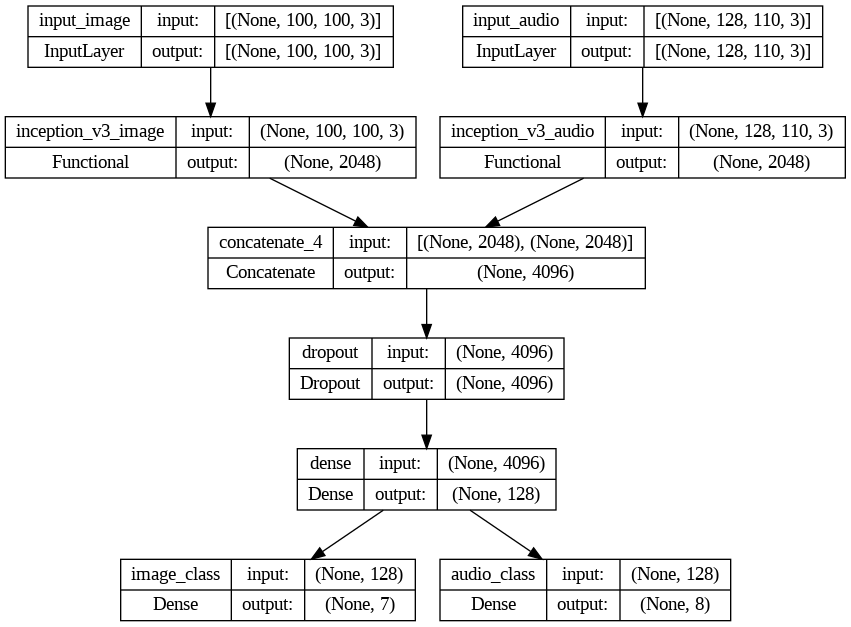

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss={
        'image_class': 'sparse_categorical_crossentropy',
        'audio_class': 'sparse_categorical_crossentropy'
    },
    metrics={
        'image_class': 'accuracy',
        'audio_class': 'accuracy' 
    }
)

In [18]:
min_samples = min(len(x_img_train), len(x_audio_train), len(y_img_train), len(y_audio_train))

# Filter inputs and labels
x_img_train = x_img_train[:min_samples]
x_audio_train = x_audio_train[:min_samples]
y_img_train = y_img_train[:min_samples]
y_audio_train = y_audio_train[:min_samples]

# Print shapes after filtering
print("Input Image Shape:", x_img_train.shape) 
print("Input Audio Shape:", x_audio_train.shape)  
print("Image Labels Shape:", y_img_train.shape) 
print("Audio Labels Shape:", y_audio_train.shape)

Input Image Shape: (19184, 100, 100, 3)
Input Audio Shape: (19184, 128, 110, 3)
Image Labels Shape: (19184,)
Audio Labels Shape: (19184,)


In [19]:
print("Input Image Type:", x_img_train.dtype) 
print("Input Audio Type:", x_audio_train.dtype)  
print("Image Labels Type:", y_img_train.dtype) 
print("Audio Labels Type:", y_audio_train.dtype)

Input Image Type: uint8
Input Audio Type: float32
Image Labels Type: int64
Audio Labels Type: int64


In [20]:
min_samples = min(len(x_img_val), len(x_audio_val), len(y_img_val), len(y_audio_val))

# Filter inputs and labels
x_img_val = x_img_val[:min_samples]
x_audio_val = x_audio_val[:min_samples]
y_img_val = y_img_val[:min_samples]
y_audio_val = y_audio_val[:min_samples]


In [21]:
tf.keras.backend.clear_session()

In [22]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= os.path.join(MODEL_CHECKPOINT_PATH, 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
    factor=0.2,
    min_lr=0.000001,
    patience=3,
    mode='min'
)

In [23]:
history = model.fit(
    x=[x_img_train, x_audio_train],
    y=[y_img_train, y_audio_train],
    validation_data=(
        [x_img_val, x_audio_val],
        [y_img_val, y_audio_val]
    ),
    callbacks=[early, checkpoint],
    epochs=300,
    batch_size=64
)


Epoch 1/300
  1/300 [..............................] - ETA: 1:38:58 - loss: 178.3952 - image_class_loss: 80.4516 - audio_class_loss: 97.9437 - image_class_accuracy: 0.1719 - audio_class_accuracy: 0.1250

I0000 00:00:1746519704.354557     148 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - ETA: 0s - loss: 21.0932 - image_class_loss: 10.2935 - audio_class_loss: 10.7996 - image_class_accuracy: 0.2207 - audio_class_accuracy: 0.1513
Epoch 1: val_loss improved from inf to 4.01320, saving model to /working/model_checkpoint/best_model.keras
300/300 [==============================] - 61s 139ms/step - loss: 21.0932 - image_class_loss: 10.2935 - audio_class_loss: 10.7996 - image_class_accuracy: 0.2207 - audio_class_accuracy: 0.1513 - val_loss: 4.0132 - val_image_class_loss: 1.9398 - val_audio_class_loss: 2.0734 - val_image_class_accuracy: 0.2471 - val_audio_class_accuracy: 0.1494
Epoch 2/300
300/300 [==============================] - ETA: 0s - loss: 4.0539 - image_class_loss: 1.9613 - audio_class_loss: 2.0926 - image_class_accuracy: 0.2498 - audio_class_accuracy: 0.1571
Epoch 2: val_loss improved from 4.01320 to 3.99880, saving model to /working/model_checkpoint/best_model.keras
300/300 [==============================] - 27s 89ms/step - l

KeyboardInterrupt: 

In [52]:
model.save('model.keras')

In [53]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [54]:
plot_and_save('loss', history, 'Loss', 'loss_plot.png')
plot_and_save('image_class_loss', history, 'Image Classification Loss', 'image_class_loss_plot.png')
plot_and_save('audio_class_loss', history, 'Audio Classification Loss', 'audio_class_loss_plot.png')
plot_and_save('image_class_accuracy', history, 'Image Classification Accuracy', 'image_class_accuracy_plot.png')
plot_and_save('audio_class_accuracy', history, 'Audio Classification Accuracy', 'audio_class_accuracy_plot.png')